In [198]:
import pandas as pd 
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import joblib
import cv2 as cv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import feature
from preprocessing import *


In [199]:
data = []

labels = {}

folders = os.listdir()
for i,value in enumerate(folders): 
    if os.path.isdir(value) and not value.startswith('.'):
        labels[i] = value
        files = os.listdir(value)
        for j in files:
            data.append({'Image': os.path.join(value, j), 'Label': i} )

df = pd.DataFrame(data)

print(labels)

df.head()

{3: 'IBM Plex Sans Arabic preprocessed', 4: 'Lemonada preprocessed', 5: 'Marhey preprocessed', 11: 'Scheherazade New preprocessed'}


,Image,Label
0,IBM Plex Sans Arabic preprocessed\0.jpeg,3
1,IBM Plex Sans Arabic preprocessed\1.jpeg,3
2,IBM Plex Sans Arabic preprocessed\10.jpeg,3
3,IBM Plex Sans Arabic preprocessed\100.jpeg,3
4,IBM Plex Sans Arabic preprocessed\101.jpeg,3


In [200]:

def precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi):
    gabor_kernels = {}
    for theta in [0 , np.pi / 8.0 , 3.0 * np.pi / 4.0]:
        for freq in lambd:
            gabor_kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, freq, gamma, psi)
            gabor_kernels[(theta, freq)] = gabor_kernel
    return gabor_kernels


def feature_extraction(img_path):
    ksize = 31
    sigma = 1.5
    lambd = [0.01 ,0.1,0.5, 4, 8, 12]
    gamma = 0.5
    psi = 0

    # Precompute Gabor Kernels
    gabor_kernels = precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi)

    # Read and preprocess image
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    
    feature_vecotr = []
    for gabor_kernel in gabor_kernels.values():
        # Apply Gabor filter
        filtered_image = cv.filter2D(image, cv.CV_64F, gabor_kernel)

        # Calculate mean and standard deviation using numpy operations
        mean_val = np.mean(filtered_image)
        std_val = np.std(filtered_image)

        # Append to feature_vecotr
        feature_vecotr.extend([mean_val, std_val])
        
    
    
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    
    passband_lower_cutoff = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]
    passband_upper_cutoff = [30, 55, 80, 105, 130, 155, 180, 205, 230, 255]

    

    
    # Create a passband filter in the frequency domain
    rows, cols = dft_shift.shape[0], dft_shift.shape[1]
    crow, ccol = rows // 2, cols // 2
    

 
    for i,lower_cutoff in enumerate(passband_lower_cutoff):
        mask = np.zeros((rows, cols, 2), np.uint8)
        mask[crow - int(passband_upper_cutoff[i]):crow + int(passband_upper_cutoff[i]), 
            ccol - int(passband_upper_cutoff[i]):ccol + int(passband_upper_cutoff[i])] = 1
        mask[crow - int(passband_lower_cutoff[i]):crow + int(passband_lower_cutoff[i]), 
            ccol - int(passband_lower_cutoff[i]):ccol + int(passband_lower_cutoff[i])] = 0  
        filtered_dft = dft_shift * mask
        magnitude_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1]) + 1e-10)
        mean = np.mean(magnitude_spectrum)
        std = np.std(magnitude_spectrum)
        feature_vecotr.extend([mean, std])

    
    return feature_vecotr



x = pd.DataFrame(df['Image'].apply(feature_extraction))
x.head()


,Image
0,"[25.05738791724787, 139.5364111367434, 25.0573..."
1,"[539.1857770770521, 945.1085633807277, 539.185..."
2,"[718.8480944116085, 951.4853745179563, 718.848..."
3,"[355.56607172044994, 339.2275538120744, 355.56..."
4,"[853.4257519320319, 1417.3866056122486, 853.42..."


In [201]:
x = pd.DataFrame(x['Image'].to_list(), columns=['Feature'+str(i) for i in range(1, len(x['Image'][0])+1)])
df = pd.concat([df, x], axis=1) 

In [209]:
df.drop('Image', axis=1, inplace=True)
df.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['Label']))
pca = PCA(n_components=52)
X_pca = pca.fit_transform(X_scaled)


joblib.dump(scaler, 'scaler_model.pkl')
joblib.dump(pca, 'pca_model.pkl')



['pca_model.pkl']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df['Label'], test_size=0.2, random_state=42)

In [215]:
X = X_pca
y= df['Label']
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)

# Train the classifier on the training data
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [216]:
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.96125


In [217]:
joblib.dump(clf, 'trained_model.pkl')

['trained_model.pkl']

### Cross validation on the test-set

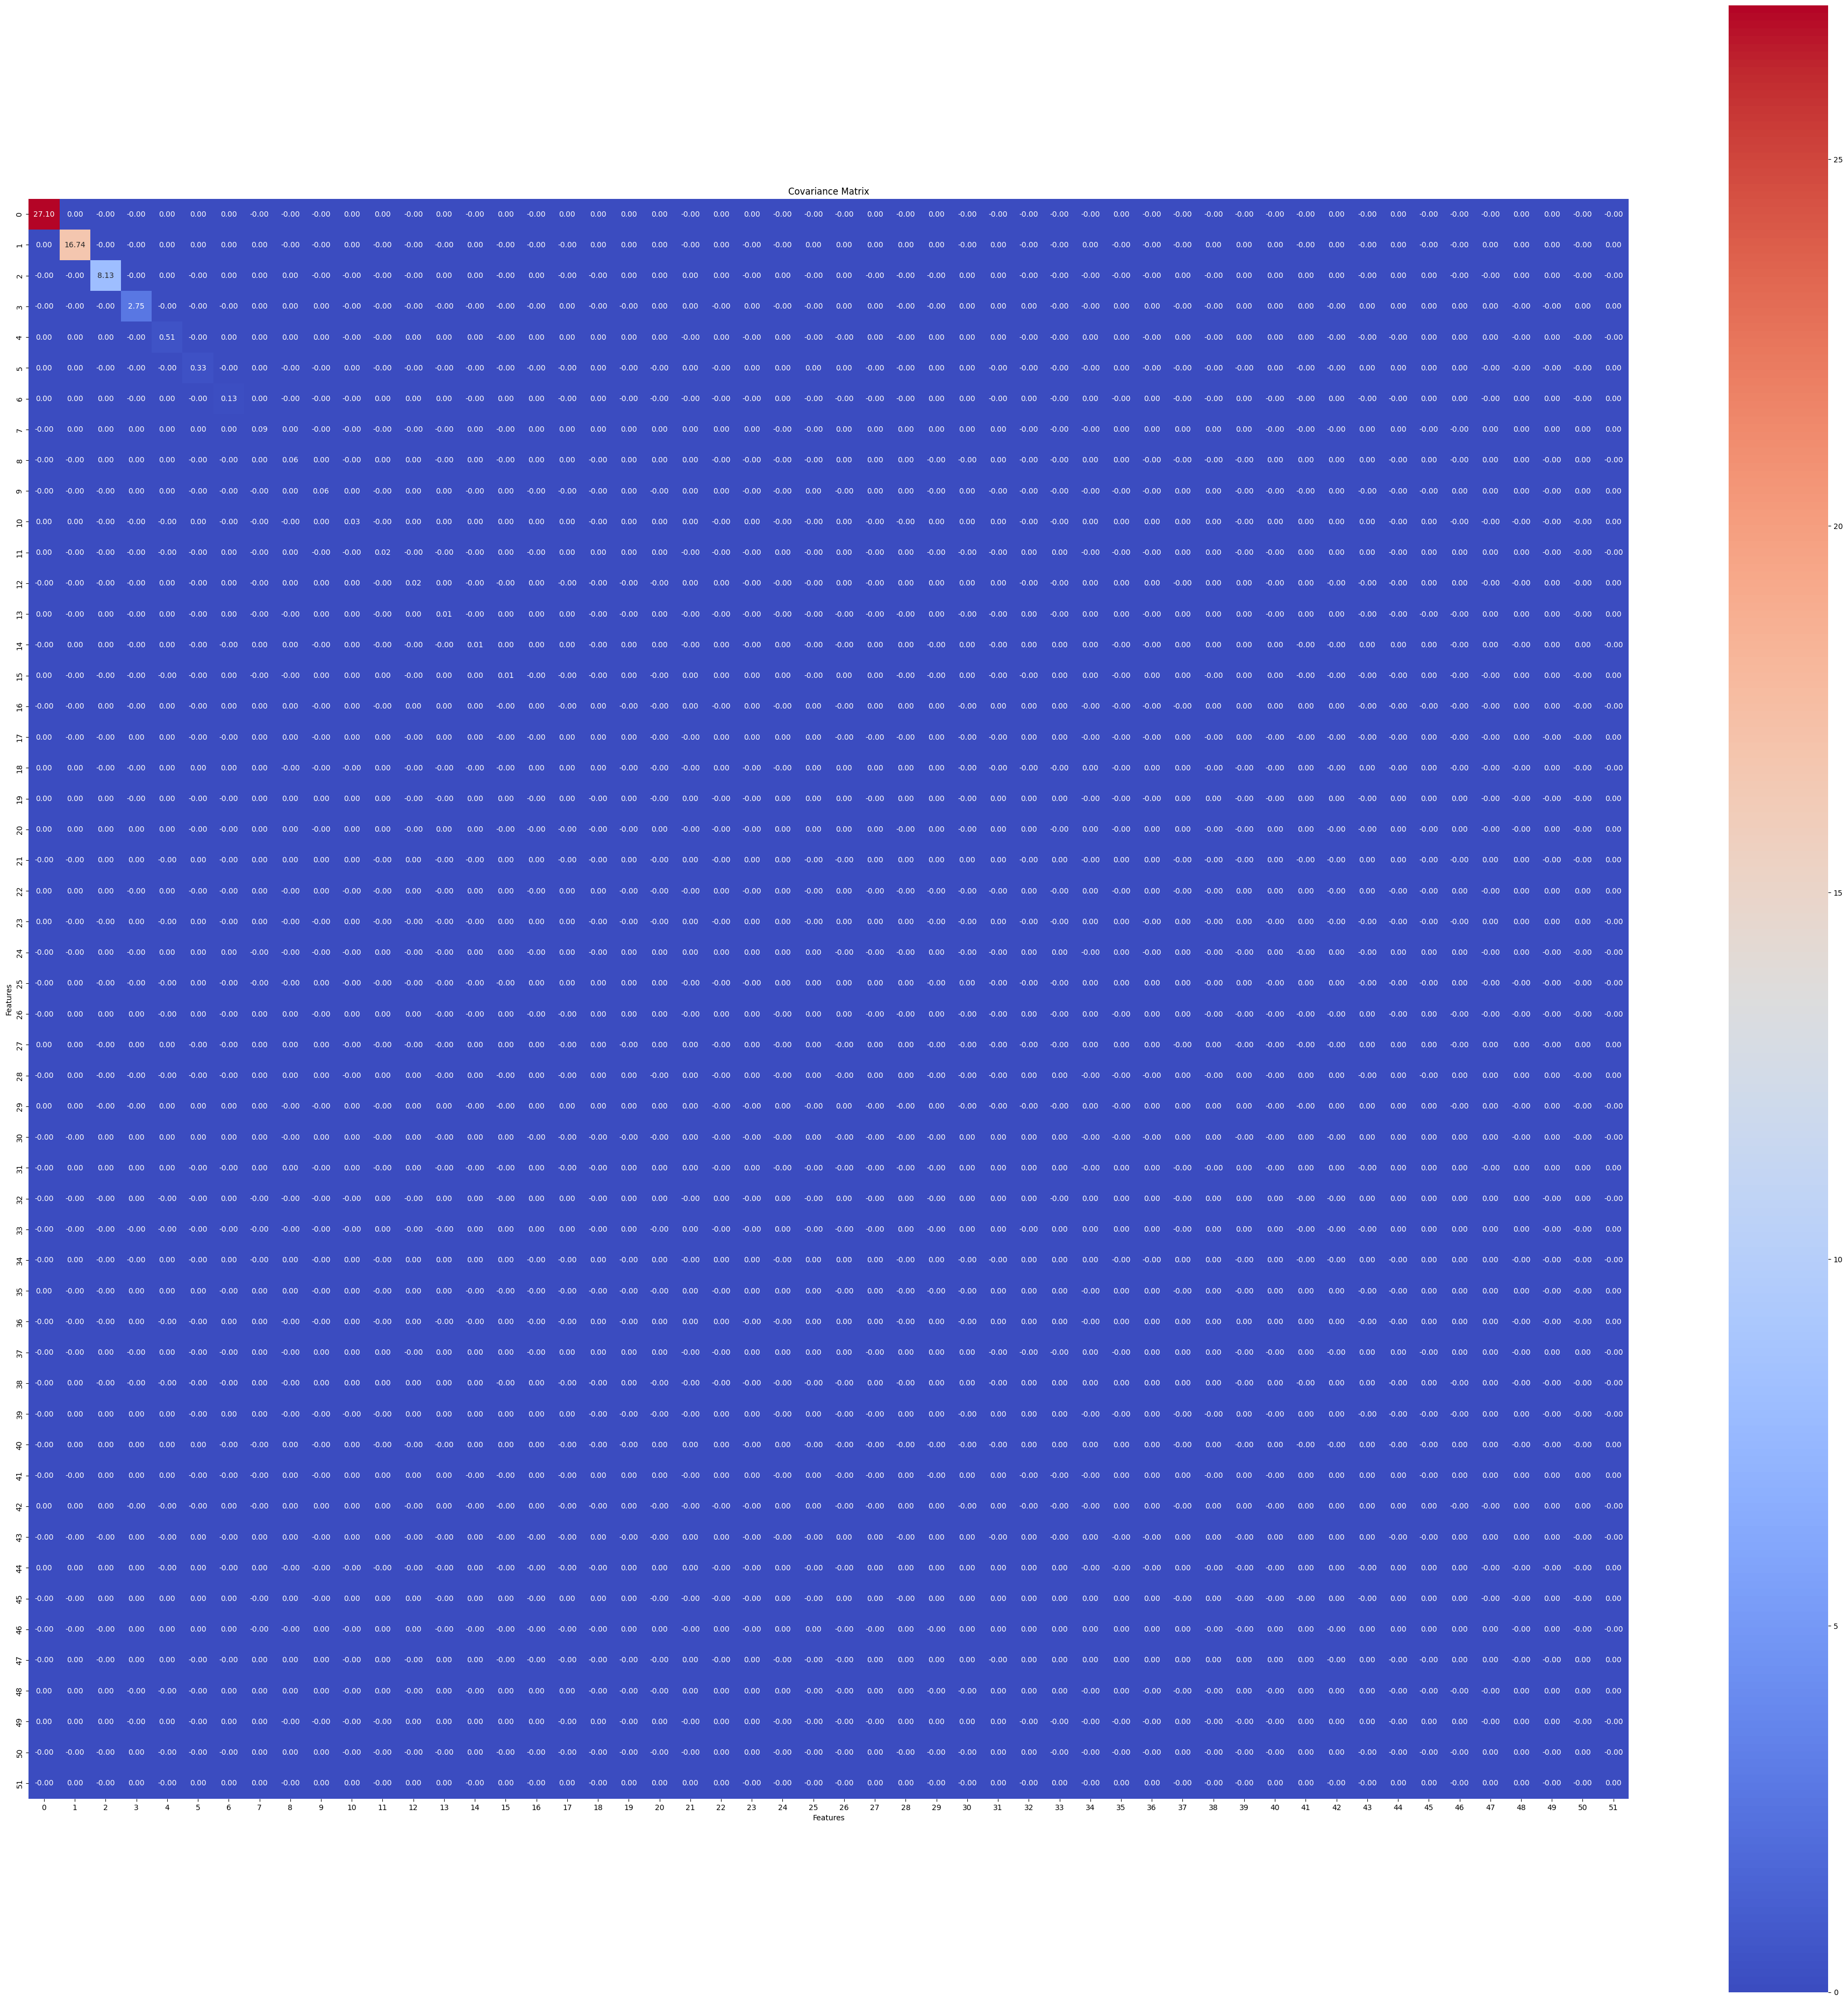

In [218]:
cov_matrix = np.cov(X, rowvar=False) 

plt.figure(figsize=(48, 48))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Covariance Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [219]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
Score = cross_val_score(clf, X, y, cv=cv)
print(Score)

[0.96    0.96375 0.96375 0.95875 0.97   ]
